In [3]:
import numpy as np
import random
import pandas as pd
import scipy.io
import matplotlib.pyplot as plt
from qiskit.quantum_info import DensityMatrix, random_density_matrix
from qiskit.quantum_info.operators import Operator
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.linalg import sqrtm


In [5]:
QST_data = pd.read_csv("../data/qst_dataset.csv")
N = QST_data.shape[0]
QST_data.head()
# clip any small values to zero
eps = 1e-10

#create boolean mask
mask = QST_data.abs() < eps
QST_data[mask] =0

X_cols = []
y_cols = []

N_x = 36
N_y = 32
for i in range(N_x):
    X_cols.append(f"x{i}")
for i in range(N_y):
    y_cols.append(f"y{i}")

X = QST_data[X_cols].to_numpy()
y = QST_data[y_cols].to_numpy()


In [ ]:
shots = X.shape[0]

# Computational basis projectors for 2 qubits
proj = []
for m in range(4):
    P = np.zeros((4, 4), dtype=complex)
    P[m, m] = 1
    proj.append(P)

# Single-qubit basis-change unitaries: X, Y, Z
H = np.array([[1, 1], [1, -1]]) / np.sqrt(2)
Sdg = np.array([[1, 0], [0, -1j]])
bases = {'X': H, 'Y': Sdg @ H, 'Z': np.eye(2)}

# Joint-Pauli settings & POVMs
settings = []
for b1 in ['X', 'Y', 'Z']:
    for b2 in ['X', 'Y', 'Z']:
        U = np.kron(bases[b1], bases[b2])
        settings.append(U)

E = []
for U in settings:
    U_dag = U.conj().T
    for P in proj:
        E.append(U_dag @ P @ U)  # 36 POVM elements

# Conversion of cholesky to rho
def params_to_rho(params):
    """Map 16 real params to a valid 4x4 density matrix via Cholesky factor."""
    L = np.zeros((4, 4), dtype=complex)
    idx = 0
    # Diagonal entries (real)
    for i in range(4):
        L[i, i] = params[idx]
        idx += 1
    # Lower-triangular off-diagonals (real + imag)
    for i in range(1, 4):
        for j in range(i):
            re = params[idx]; im = params[idx + 1]
            L[i, j] = re + 1j * im
            idx += 2
    rho = L @ L.conj().T
    return rho / np.trace(rho)


def log_prior(params):
    """Vague (flat) prior over params."""
    return 0.0

def log_likelihood(params, counts):
    """Log-likelihood of multinomial counts given params."""
    rho = params_to_rho(params)
    probs = np.array([np.real(np.trace(Ej @ rho)) for Ej in E])
    probs = np.clip(probs, 1e-10, 1.0)
    return np.sum(counts * np.log(probs))

def log_posterior(params, counts):
    """Sum of log_prior and log_likelihood."""
    return log_prior(params) + log_likelihood(params, counts)


#metropolis hastings sampler
def metropolis_sampler(counts, n_samples=2000, proposal_std=0.01, burn_in=1000):
    D = 16
    # Initial Cholesky params: identity-like
    current = np.zeros(D)
    current[:4] = np.sqrt(1/4)
    current_log_post = log_posterior(current, counts)
    
    samples = []
    for t in range(n_samples + burn_in):
        proposal = current + np.random.normal(scale=proposal_std, size=D)
        prop_log_post = log_posterior(proposal, counts)
        # Acceptance
        if np.log(np.random.rand()) < (prop_log_post - current_log_post):
            current, current_log_post = proposal, prop_log_post
        if t >= burn_in:
            samples.append(current.copy())
    return np.array(samples)



Mean fidelity: 0.8583 ± 0.0682


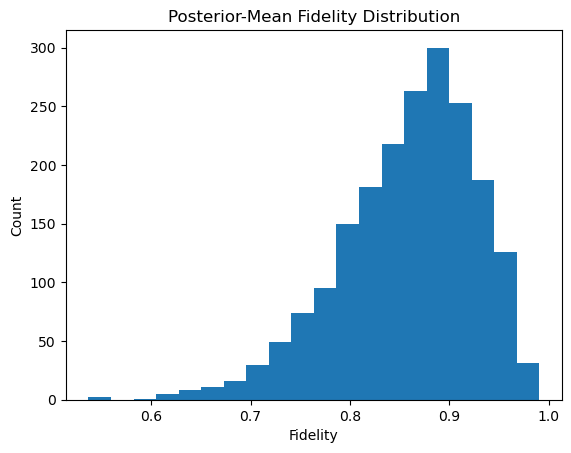

In [ ]:
N = X.shape[0]
fidelities = np.zeros(N)

for i in range(N):
    # 1) get counts
    counts = (X[i] * shots).astype(int)
    # 2) sample posterior params
    samples = metropolis_sampler(counts, n_samples=1000, proposal_std=0.01, burn_in=500)
    # 3) map to rho samples & compute posterior mean
    rho_samples = np.array([params_to_rho(s) for s in samples])
    rho_mean = np.mean(rho_samples, axis=0)
    # 4) reconstruct true rho
    real = y[i, :16].reshape(4, 4)
    imag = y[i, 16:].reshape(4, 4)
    rho_true = real + 1j * imag
    # 5) compute fidelity
    sqrt_rho_true = sqrtm(rho_true)
    F = np.trace(sqrtm(sqrt_rho_true @ rho_mean @ sqrt_rho_true))**2
    fidelities[i] = np.real(F)


mean_fid = np.mean(fidelities)
std_fid  = np.std(fidelities)
print(f"Mean fidelity: {mean_fid:.4f} ± {std_fid:.4f}")


plt.hist(fidelities, bins=20)
plt.title("Posterior-Mean Fidelity Distribution")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.show()